In [1]:
!pip install theano
!pip install pymc3
from sklearn.datasets import make_circles,make_moons
import theano
floatX = theano.config.floatX
from pandas import DataFrame
import numpy as np
from sklearn.preprocessing import scale
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import theano.tensor as T
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


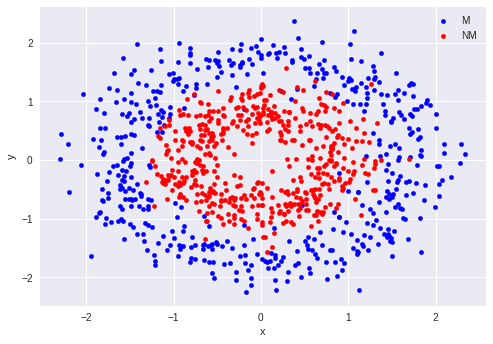

In [2]:
X, Y = make_circles(n_samples=1000,noise=0.15, factor=0.5, random_state=1)
X = scale(X)
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
colors = {0:'blue', 1:'red'}
fig, ax = plt.subplots()
names = ["M","NM"]
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=names[key], color=colors[key])
plt.savefig("scatterplotNUTS3.png",dpi=600)
from google.colab import files
files.download( "scatterplotNUTS3.png")

In [36]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

1000

In [0]:
def construct_nn(ann_input, ann_output):
    n_hidden = 8
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_3 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
       
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)
        
        weights_2_3 = pm.Normal('w_2_3', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_3)
       
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        act_1 = pm.math.sigmoid(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.sigmoid(pm.math.dot(act_1,
                                         weights_1_2))
        act_3= pm.math.sigmoid(pm.math.dot(act_2,
                                         weights_2_3))
        act_out = pm.math.sigmoid(pm.math.dot(act_3,
                                              weights_2_out))
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] 
                          )
    return neural_network

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [0]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [39]:
from scipy import optimize

with neural_network:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w_2_out, w_2_3, w_1_2, w_in_1]
 54%|█████▍    | 541/1000 [01:39<01:24,  5.45it/s]

100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [0]:
trace = approx.sample(draws=5000)

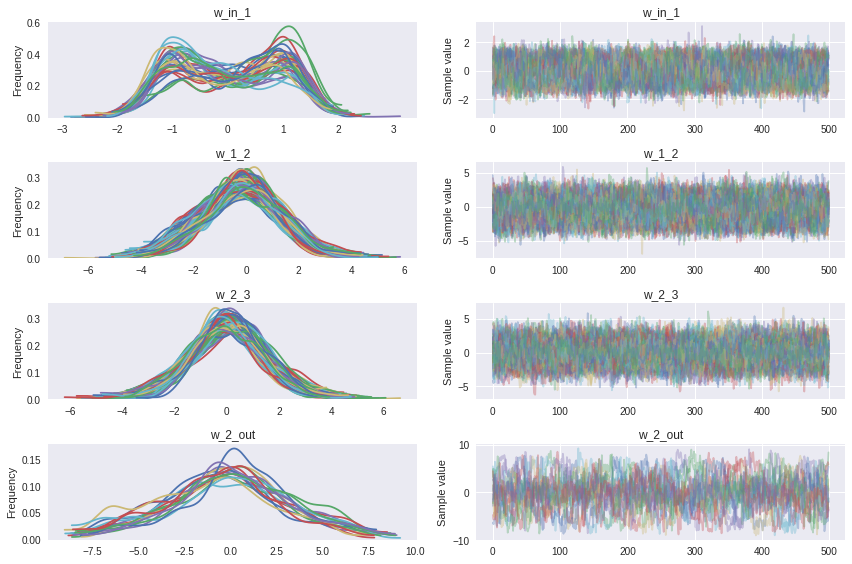

In [41]:
_ = pm.traceplot(trace)
plt.savefig('traceplotNUTS.png', dpi=600)
from google.colab import files
files.download( "traceplotNUTS.png" )

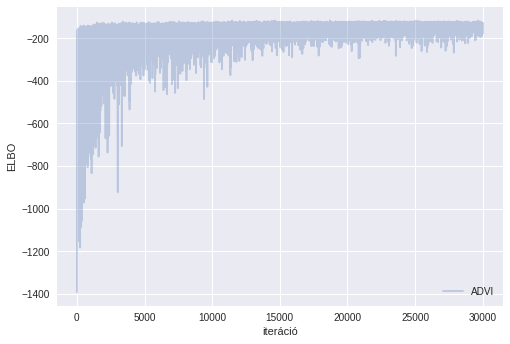

In [53]:
plt.plot(-inference.hist, label='ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteráció');
plt.savefig("elbo.png",dpi=1000)
from google.colab import files
files.download( "elbo.png")

In [42]:
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

ppc = pm.sample_ppc(trace, model=neural_network, samples=500) 

pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:00<00:00, 1084.96it/s]


[Text(0,0.5,'Y'),
 Text(0.5,0,'X'),
 Text(0.5,1,'Prediktált értékek a teszt halmazon')]

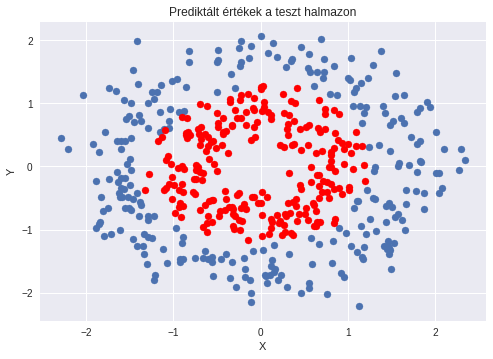

In [43]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Prediktált értékek a teszt halmazon', xlabel='X', ylabel='Y')

In [44]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 94.6%


In [46]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

100%|██████████| 500/500 [00:04<00:00, 103.32it/s]


Text(0,0.5,'Az 1-es osztályba tartozás posteriori valószínűségei')

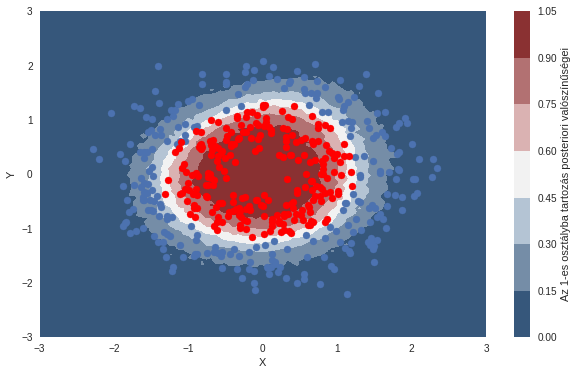

In [47]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Az 1-es osztályba tartozás posteriori valószínűségei')

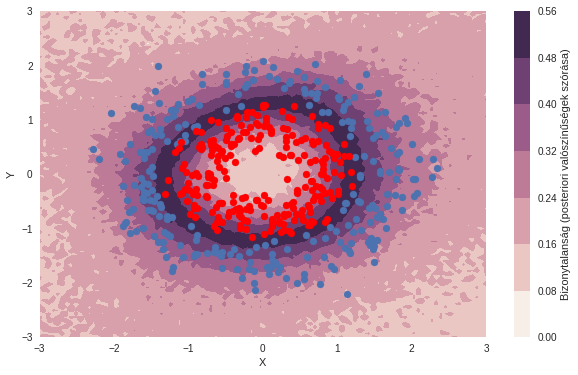

In [48]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Bizonytalanság (posteriori valószínűségek szórása)');